In [1]:
# !pip install scikit-uplift==0.2.0

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных на тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter('ignore')

<b>recency</b> - months since last purchase  
<b>history</b> - value of the historical purchases  
<b>used_discount</b> - indicates if the customer used a discount before  
<b>used_bogo</b> - indicates if the customer used a buy one get one before  
<b>zip_code</b> - class of the zip code as Suburban/Urban/Rural  
<b>is_referral</b> - indicates if the customer was acquired from referral channel  
<b>channel</b> - channels that the customer using, Phone/Web/Multichannel  
<b>offer</b> - the offers sent to the customers, Discount/But One Get One/No Offer <b>treatment</b>  
<b>conversion</b> - customer conversion(buy or not) <b>target</b>  

In [3]:
def df_conv(df: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler(with_mean=False)
    df_result = df.copy()
    dum_cols = []
    conv_cols = []
    
    df_result.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)
    df_result['treatment'] = np.where(df_result['treatment'] == 'No Offer', 0 , 1)
    
    for col in df_result.columns:
        if df_result[col].nunique() == 2:
            conv_cols.append(col)
        elif df_result[col].nunique() == 3:
            dum_cols.append(col)
    
    df_result = pd.get_dummies(df_result, prefix=dum_cols)
    df_result[conv_cols] = df_result[conv_cols].astype(np.uint8)
    df_result['history'] = scaler.fit_transform(np.asarray(df_result['history']).reshape(-1, 1))
    
    return df_result

In [4]:
df = pd.read_csv('data.csv')
df.shape

(64000, 9)

In [5]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
df = df_conv(df)
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,0.556066,1,0,0,1,0,0,1,0,0,1,0
1,6,1.284683,1,1,1,0,0,1,0,0,0,0,1
2,7,0.705233,0,1,1,1,0,0,1,0,0,0,1
3,9,2.638347,1,0,1,1,0,1,0,0,0,0,1
4,2,0.177001,1,0,0,1,0,0,0,1,0,0,1


___

In [7]:
df.target.value_counts(normalize=True)

0    0.853219
1    0.146781
Name: target, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), 
                                                    df['target'],
                                                    random_state=42)
train_treat = X_train['treatment']
test_treat = X_test['treatment']

X_train.drop('treatment', axis=1, inplace=True)
X_test.drop('treatment', axis=1, inplace=True)

**Solo Model**

uplift@30%: 0.0839


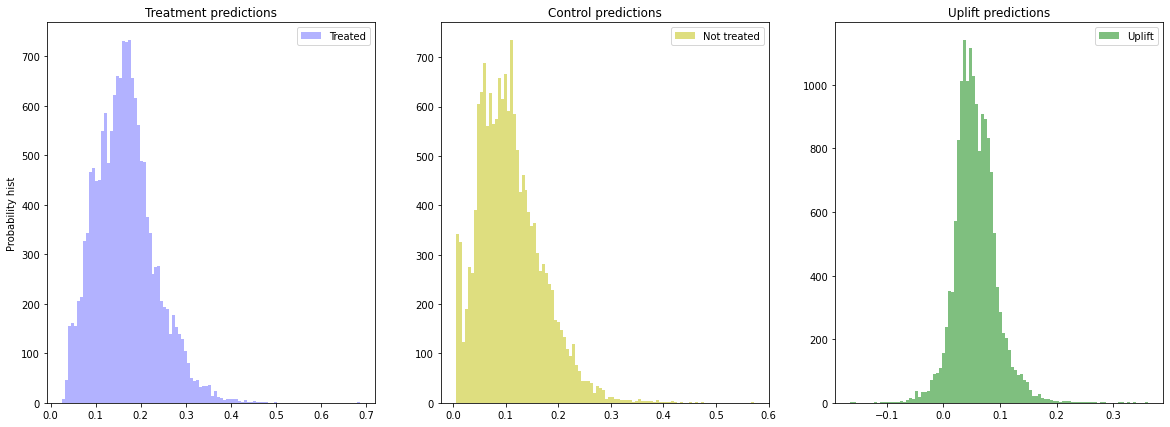

In [9]:
sm = SoloModel(LGBMClassifier(random_state=42, silent=True))
sm = sm.fit(X_train, y_train, train_treat)
uplift_sm = sm.predict(X_test)
sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treat, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [10]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_name_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi.head(5)

,feature_name,feature_score
0,history,1290
1,recency,606
2,is_referral,140
3,zip_code_Rural,139
4,used_bogo,138


**Class transformation**

In [11]:
ct = ClassTransformation(LGBMClassifier(random_state=42, silent=True))
ct = ct.fit(X_train, y_train, train_treat)
uplift_ct = ct.predict(X_test)
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=test_treat, strategy='by_group', k=0.3)
print(f'uplift@30%: {ct_score:.4f}')

uplift@30%: 0.0876


In [12]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_name_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi.head(5)

,feature_name,feature_score
0,history,1374
1,recency,703
2,used_discount,146
3,channel_Phone,117
4,is_referral,112


**Two models**

uplift@30%: 0.0839


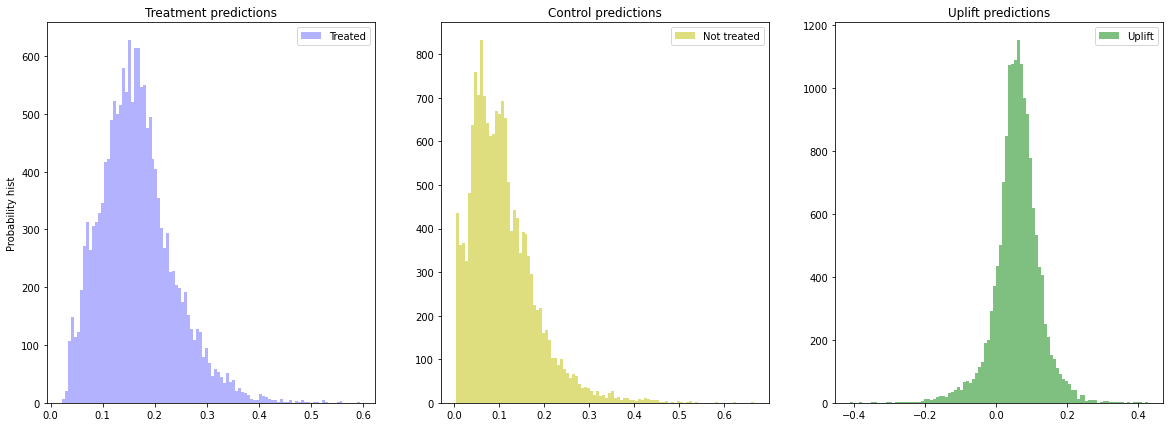

In [13]:
tm = TwoModels(
    estimator_trmnt=LGBMClassifier(random_state=42, silent=True), 
    estimator_ctrl=LGBMClassifier(random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, train_treat,)

uplift_tm = tm.predict(X_test)
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=test_treat, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [14]:
model_names = ['SoloModel', 'ClassTransformation', 'TwoModels']
model_uplifts = [uplift_sm, uplift_ct, uplift_tm]
result_list = []
for i in np.arange(0.1, 0.35, 0.1):
    tmp_list = []
    for n_upl, model in enumerate(model_names):
        tmp_list.append (uplift_at_k(y_true=y_test, 
                                     uplift=model_uplifts[n_upl], 
                                     treatment=test_treat, 
                                     strategy='by_group', k=i))
    result_list.append(tmp_list)
model_results_df = pd.DataFrame(result_list, index=['uplift@10%', 'uplift@20%', 'uplift@30%'],
                               columns=model_names)

In [15]:
model_results_df

,SoloModel,ClassTransformation,TwoModels
uplift@10%,0.121968,0.089168,0.099422
uplift@20%,0.084729,0.094123,0.086099
uplift@30%,0.083859,0.087637,0.073527


___

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

К сожалению, выполнить это задание не получилось, по причине конфликта зависимостей:  
<code>ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
causalml 0.10.0 requires numpy<1.19.0,>=0.16.0, but you have numpy 1.19.5 which is incompatible.
causalml 0.10.0 requires scikit-learn<0.24.0,>=0.22.0, but you have scikit-learn 0.24.2 which is incompatible.
causalml 0.10.0 requires scipy==1.4.1, but you have scipy 1.6.3 which is incompatible.
causalml 0.10.0 requires shap<0.38.1, but you have shap 0.39.0 which is incompatible.</code>

При попытке установить требуемые версии, начинают вылезать ошибки в зависимостях других пакетов - например tensorflow 2.5.0 требует numpy 1.19.2, а такой numpy не подходит causalml и т.п.